## Features

* https://paper.dropbox.com/doc/Features-uedG9wB1hIWGBYz63TBpi

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

In [191]:
DATA_DIR = '../data/'
img_fpath = os.path.join(DATA_DIR, 'segmentation', 'bimodal.jpg')
FIGSIZE=(8,8)

In [205]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def plot_two_imgs(img1, img2, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap=cmap)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap=cmap)
    plt.title(title)
    plt.show()

## Edges

In [206]:
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3,3))
erode_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3,3))

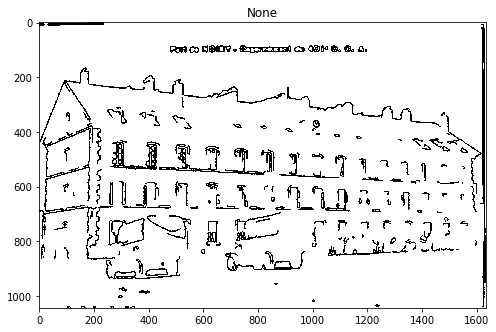

In [207]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)

# Opening
img = cv2.erode(img, erode_kernel, iterations = 2)
img = cv2.dilate(img, dilate_kernel, iterations = 2)

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=5)

lower_threshold = 125
upper_threshold = 225
edges = cv2.Canny(gray, lower_threshold, upper_threshold)

edges = cv2.dilate(edges, dilate_kernel, iterations = 2)
plot_img(cv2.bitwise_not(edges))

## Contours

* Contours "connect the dots" and group similar points into lines and curves
* Pass in corners or edges from Canny 
* https://docs.opencv.org/3.3.1/d4/d73/tutorial_py_contours_begin.html
* https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

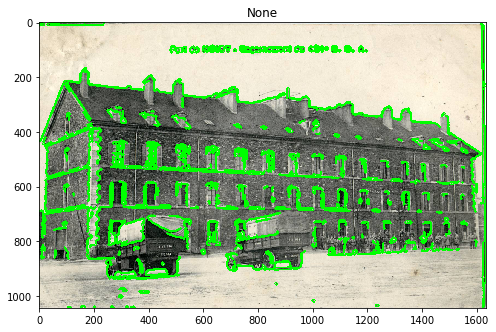

In [208]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
im2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0,255,0), 3)
plot_img(img)

## Moments

* Image moments help you to calculate the center or area of a contour

In [209]:
cnt = contours[0]
M = cv2.moments(cnt)

# Centroid
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

## Harris Corners

* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
* https://matlabcorner.wordpress.com/2012/11/17/does-harris-corner-detector-finds-corners-intuitive-explanation-to-harris-corner-detector/

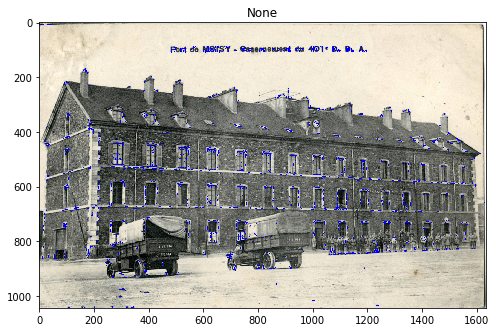

In [210]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)

# Opening
dst = cv2.erode(img.copy(), erode_kernel, iterations = 2)
dst = cv2.dilate(dst, dilate_kernel, iterations = 2)

# Grayscale
gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, ksize=(7,7), sigmaX=5)

# Corners
dst = cv2.cornerHarris(gray, 2, 3, .04)

# Dilate result for plotting the corners (not important)
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plot_img(img)

## Shi Tomasi Corners

* https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html

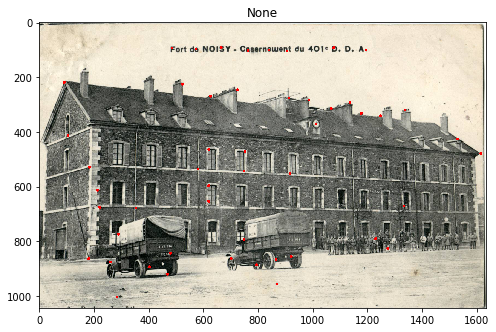

In [211]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# "goodFeaturesToTrack" implements Shi-Tomasi by default
corners = cv2.goodFeaturesToTrack(gray, maxCorners=50, qualityLevel=.01, minDistance=50)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img, (x,y), 5, 255, -1)

plot_img(img)

## Gaussian Pyramid

* http://eric-yuan.me/image-pyramids/
* Convolve with gaussian kernel
* Downsample (remove even rows)

![](http://eric-yuan.me/wp-content/uploads/2013/10/111.png)

(1044, 1633, 3)
(522, 817, 3)
(261, 409, 3)
(131, 205, 3)


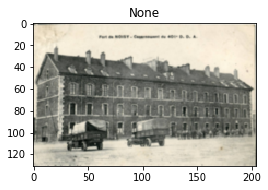

In [212]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
print(img.shape)
img = cv2.pyrDown(img)
print(img.shape)
img = cv2.pyrDown(img)
print(img.shape)
img = cv2.pyrDown(img)
print(img.shape)
plot_img(img, fs=(4,4))

## Laplacian Pyramid

* Difference between two levels in the gaussian pyramid
* The smaller level is upsampled to match the larger

![](http://eric-yuan.me/wp-content/uploads/2013/10/lap.jpg)

## SIFT

* Scale Invariant Feature Transform
* http://eric-yuan.me/sift/
* [OpenCV Tutorial](https://docs.opencv.org/3.3.0/da/df5/tutorial_py_sift_intro.html)

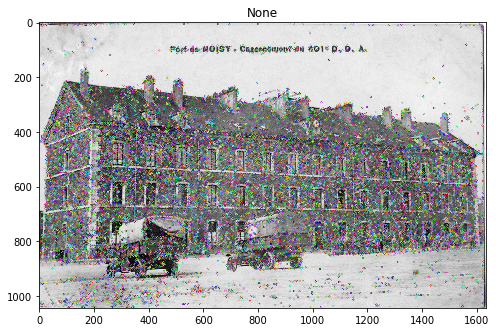

In [213]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kps, descs = sift.detectAndCompute(gray, None)

img = cv2.drawKeypoints(gray, kps, None)

plot_img(img)

## SURF

* Speeded Up Robust Features
* Approximates LoG with Box Filter
* [OpenCV Tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html#surf)

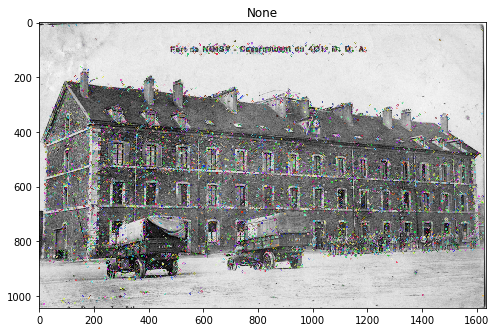

128

In [214]:
img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

surf = cv2.xfeatures2d.SURF_create(hessianThreshold=1000, extended=True)
kps, descs = surf.detectAndCompute(gray, None)

img = cv2.drawKeypoints(gray, kps, None)

plot_img(img)
len(descs[0])

## Feature Matching

* https://paper.dropbox.com/doc/Feature-Matching-YQR4yRl7x5nDRoV5CB2DF
* http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html#matcher
* http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html#feature-homography

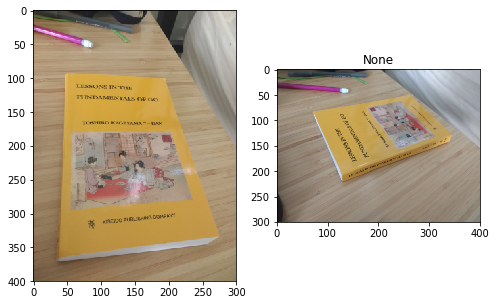

In [215]:
def resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        # calculate the ratio of the height and construct dims
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

img_fpath1 = os.path.join(DATA_DIR, 'book1.jpg')
img_fpath2 = os.path.join(DATA_DIR, 'book2.jpg')
img1 = resize(load_cv2_img(img_fpath1, colorspace=cv2.COLOR_BGR2RGB), height=400)
img2 = resize(load_cv2_img(img_fpath2, colorspace=cv2.COLOR_BGR2RGB), width=400)
plot_two_imgs(img1, img2)

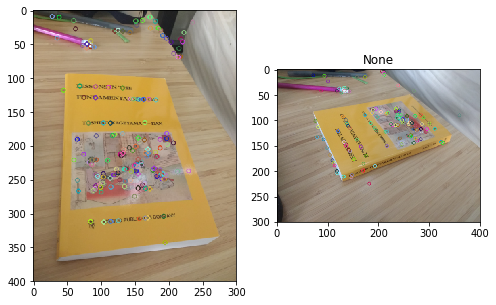

In [217]:
def get_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kps, descs = sift.detectAndCompute(gray, None)
    return kps, descs

kps1,descs1 = get_features(img1)
img1 = cv2.drawKeypoints(img1, kps1, None)
kps2,descs2 = get_features(img2)
img2 = cv2.drawKeypoints(img2, kps2, None)
plot_two_imgs(img1, img2)

## Brute Force Matching

* Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.
* [OpenCV Tutorial](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html#matcher)

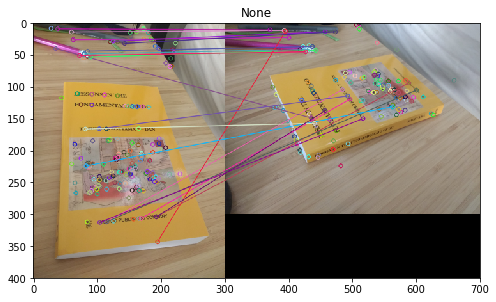

In [218]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descs1, descs2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
draw_n = 20
img3 = cv2.drawMatches(img1, kps1, img2, kps2, matches[:draw_n], flags=2, outImg=None)

plot_img(img3)

Matches 21


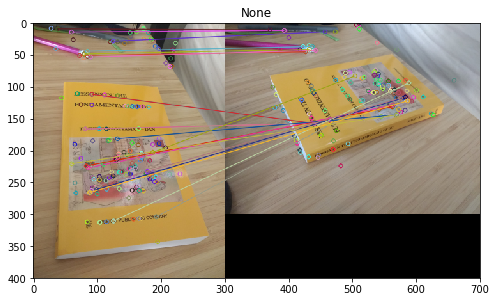

In [219]:
# K Best Matches for Lowe's Ratio Test
bf = cv2.BFMatcher()

# This returns the top two matches found for each feature point
matches = bf.knnMatch(descs1, descs2, k=2)

# Apply ratio test
# Lowe suggests that good feature matches will "stand out"
# Where the closer match error distance is significantly less
# Than the second closest match distance
# In this case we ask for a margin of 25%
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
print("Matches", len(good))
img3 = cv2.drawMatchesKnn(img1, kps1, img2, kps2, good, flags=2, outImg=None)
plot_img(img3)

## Approximate Nearest Neighbors

* Brute force is super slow, so let's approximate
* FLANN = Fast Library for Approximate Nearest Neighbors
* Not working for me (OpenCV Bug https://github.com/opencv/opencv/issues/5667)

## RANSAC

* Feature matching technique
* [Tutorial](http://opencv-python-
tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html#feature-homography)
* It's important that the images have a lot of matches. That the objects inside the image are distinct and easily recognizable
* My Shiney orange go book did not return enough feature matches to compute a good homography

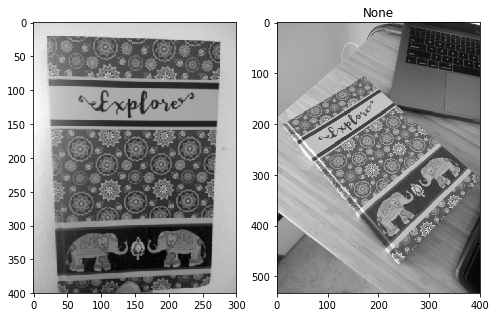

In [221]:
img_fpath1 = os.path.join(DATA_DIR, 'journal1.jpg')
img_fpath2 = os.path.join(DATA_DIR, 'journal2.jpg')
src_img = resize(load_cv2_img(img_fpath1, colorspace=cv2.COLOR_BGR2GRAY), height=400)
dst_img = resize(load_cv2_img(img_fpath2, colorspace=cv2.COLOR_BGR2GRAY), width=400)
plot_two_imgs(src_img, dst_img)

In [222]:
# Extract SIFT Features
sift = cv2.xfeatures2d.SIFT_create()
src_keypoints, src_desc = sift.detectAndCompute(src_img, None)
dst_keypoints, dst_desc = sift.detectAndCompute(dst_img, None)

In [223]:
# Match Features across images
bf = cv2.BFMatcher()
matches = bf.knnMatch(src_desc, dst_desc, k=2)
goodMatches = []

for m, n in matches:
    if m.distance < 0.7 * n.distance:
        goodMatches.append(m)
        
print("Matches", len(goodMatches))

Matches 289


In [224]:
# Use RANSAC to Fit the best Homography (one with most inliers)
sourcePoints = np.float32(
    [ src_keypoints[m.queryIdx].pt for m in goodMatches ]).reshape(-1, 1, 2)
destinationPoints = np.float32(
    [ dst_keypoints[m.trainIdx].pt for m in goodMatches ]).reshape(-1, 1, 2)

# Obtain the homography matrix
M, mask = cv2.findHomography(sourcePoints, destinationPoints, 
                             method=cv2.RANSAC, ransacReprojThreshold=5.0)
matchesMask = mask.ravel().tolist()

# Apply the perspective transformation to the source image corners
h, w = src_img.shape
corners = np.float32([ [0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0] ]).reshape(-1, 1, 2)
transformedCorners = cv2.perspectiveTransform(corners, M)

# Draw a polygon on the dst image joining the transformed corners
dst_img = cv2.polylines(dst_img, [np.int32(transformedCorners)], 
                        True, (255, 255, 255), 2, cv2.LINE_AA)

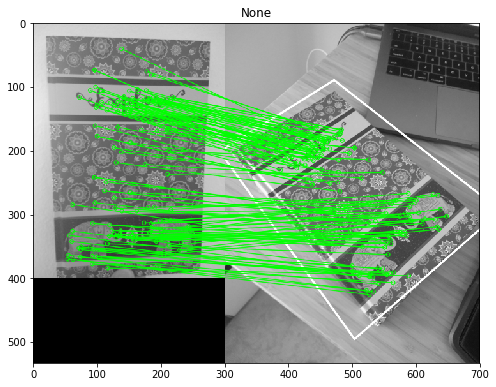

In [225]:
drawParameters = dict(matchColor=(0, 255, 0), 
                      singlePointColor=None, 
                      matchesMask=matchesMask, flags=2)

result = cv2.drawMatches(src_img, src_keypoints, dst_img, dst_keypoints, 
                         goodMatches, None, **drawParameters)
plot_img(result)

## Warp Perspective

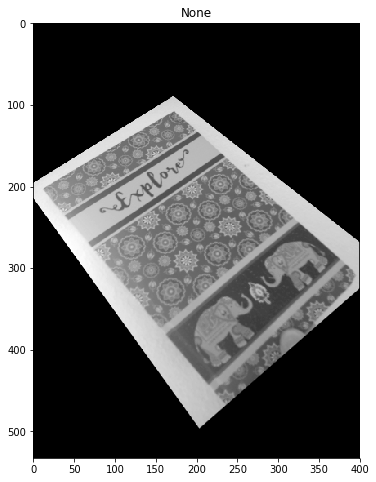

In [226]:
# Warp SRC --> DST orientation
h, w = dst_img.shape
warp = cv2.warpPerspective(src_img, M, (w, h))
plot_img(warp)

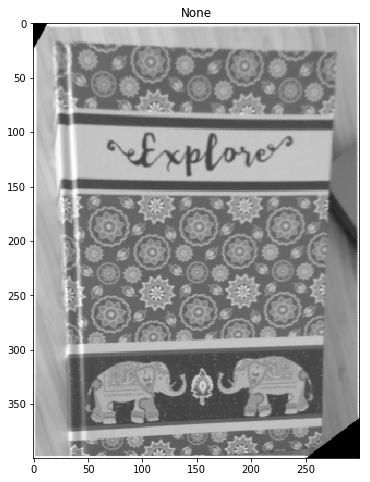

In [227]:
# Warp DST --> SRC orientation
M_inv = np.linalg.inv(M) # The inverse matrix has the opposite effect
h, w = src_img.shape
warp = cv2.warpPerspective(dst_img, M_inv, (w, h))
plot_img(warp)